In [1]:
import random
import torch
import matplotlib.pyplot as plt
import supervision as sv
import numpy as np
import cv2

from pathlib import Path
from ultralytics import YOLO
from tqdm import tqdm
from transformers import SiglipImageProcessor, SiglipVisionModel
from PIL import Image
from collections import defaultdict
from sklearn.cluster import KMeans

In [2]:
MODEL_PATH = Path("runs/detect/train12/weights/best.pt")
VAL_IMAGES_DIR = Path("data/tracking/YOLO/images/val")
VIDEO_OUT_DIR = Path("videos")
VIDEO_OUT_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = YOLO(str(MODEL_PATH))
model.to(device)
print("Loaded model from:", MODEL_PATH)

names = model.names  
print("Classes:", names)

Using device: cuda
Loaded model from: runs/detect/train12/weights/best.pt
Classes: {0: 'player', 1: 'referee', 2: 'ball'}


Inference on: SNMOT-170_000617.jpg


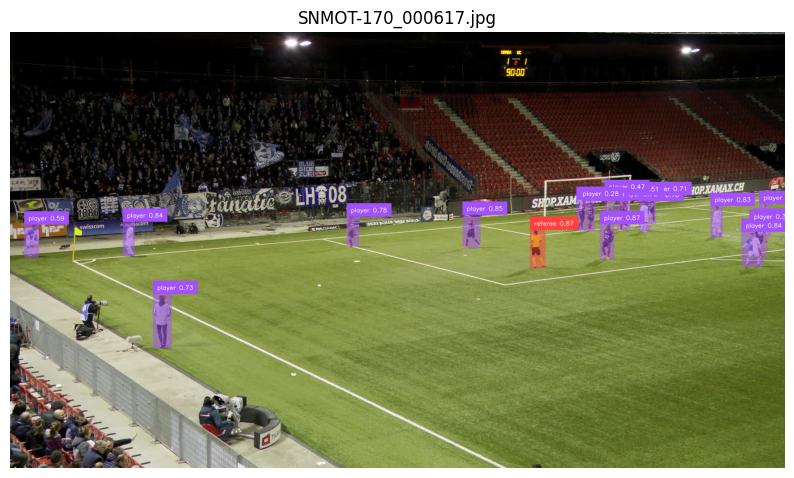

In [4]:
img_path = random.choice(list(Path(VAL_IMAGES_DIR).glob("*.jpg")))
print("Inference on:", img_path.name)

result = model(str(img_path), imgsz=640, device=device, verbose=False)[0]

detections = sv.Detections.from_ultralytics(result)

labels = [
    f"{names[int(cls_id)]} {conf:.2f}"
    for cls_id, conf in zip(detections.class_id, detections.confidence)
]

image_bgr = cv2.imread(str(img_path))

color_annotator = sv.ColorAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_bgr = color_annotator.annotate(
    scene=image_bgr.copy(),
    detections=detections
)
annotated_bgr = label_annotator.annotate(
    scene=annotated_bgr,
    detections=detections,
    labels=labels
)

annotated_rgb = cv2.cvtColor(annotated_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(annotated_rgb)
plt.axis("off")
plt.title(img_path.name)
plt.show()

## Tracking

In [5]:

VAL_IMAGES_DIR = Path("data/tracking/YOLO/images/val")

all_imgs = list(VAL_IMAGES_DIR.glob("SNMOT-*_*.jpg"))

max_frames = None

match_ids = sorted({p.stem.split("_")[0] for p in all_imgs})
print(f"Found {len(match_ids)} matches: {match_ids}")

selected_match = random.choice(match_ids)
print(f"Selected Match: {selected_match}")

match_frames = [p for p in all_imgs if p.stem.startswith(selected_match + "_")]

match_frames = sorted(match_frames, key=lambda p: int(p.stem.split("_")[1]))

if max_frames and len(match_frames) > max_frames:
    match_frames = match_frames[:max_frames]

print(f"Frames to process: {len(match_frames)}")

Found 12 matches: ['SNMOT-159', 'SNMOT-160', 'SNMOT-161', 'SNMOT-162', 'SNMOT-163', 'SNMOT-164', 'SNMOT-165', 'SNMOT-166', 'SNMOT-167', 'SNMOT-168', 'SNMOT-169', 'SNMOT-170']
Selected Match: SNMOT-169
Frames to process: 750


In [ ]:

model = YOLO("runs/detect/train12/weights/best.pt") 
tracker = sv.ByteTrack()

tracking_results = [] 

print("Starting Tracking...")
for img_path in tqdm(match_frames):
    frame = cv2.imread(str(img_path))
    
    result = model(frame, imgsz=640, verbose=False)[0]
    
    detections = sv.Detections.from_ultralytics(result)
    
    # 3. Track (Assigns IDs)
    detections = tracker.update_with_detections(detections)
    
    # 4. Store Result 
    tracking_results.append({
        "frame_path": img_path,
        "detections": detections,
        "frame_shape": frame.shape[:2] # (h, w)
    })

print(f"Tracking complete. Stored data for {len(tracking_results)} frames.")

Starting Tracking...


  2%|▏         | 14/750 [00:00<00:22, 32.46it/s]

100%|██████████| 750/750 [00:19<00:00, 38.37it/s]

Tracking complete. Stored data for 750 frames.


In [7]:
for i, data in enumerate(tracking_results):
    dets = data["detections"]
    if len(dets) > 0:
        print(f"Frame {i}: Found {len(dets)} objects.")
        print("Tracker IDs:", dets.tracker_id)
        print("Class IDs:", dets.class_id)
        break
else:
    print("No detections found in the entire clip.")

Frame 0: Found 12 objects.
Tracker IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12]
Class IDs: [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
VIDEO_OUT_DIR = Path("videos")
VIDEO_OUT_DIR.mkdir(parents=True, exist_ok=True)

first_frame_shape = tracking_results[0]["frame_shape"] # (h, w)
out_path = VIDEO_OUT_DIR / f"{selected_match}_tracked.mp4"
fps = 25
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter(str(out_path), fourcc, fps, (first_frame_shape[1], first_frame_shape[0]))

color_annotator = sv.ColorAnnotator()
label_annotator = sv.LabelAnnotator()

print(f"Rendering video to {out_path}...")

for data in tqdm(tracking_results):
    # Reload image from path (saves RAM vs keeping all images in memory)
    frame = cv2.imread(str(data["frame_path"]))
    detections = data["detections"]

    labels = [
        f"#{tracker_id} {model.names[int(cls_id)]}"
        for tracker_id, cls_id 
        in zip(detections.tracker_id, detections.class_id)
    ]

    # Annotate
    annotated = color_annotator.annotate(scene=frame, detections=detections)
    annotated = label_annotator.annotate(
        scene=annotated,
        detections=detections,
        labels=labels
    )

    writer.write(annotated)

writer.release()
print("Done!")

Rendering video to videos/SNMOT-169_tracked.mp4...


  0%|          | 3/750 [00:00<00:29, 25.01it/s]

 39%|███▊      | 290/750 [00:09<00:15, 30.40it/s]


KeyboardInterrupt: 

## Segmentación entre equipos


In [9]:
print("Loading SigLIP model...")
processor = SiglipImageProcessor.from_pretrained("google/siglip-base-patch16-224")
embed_model = SiglipVisionModel.from_pretrained("google/siglip-base-patch16-224").to(device)

def get_crop(frame, xyxy):
    """Crops the image and converts to PIL format (RGB)"""
    x1, y1, x2, y2 = map(int, xyxy)
    h, w = frame.shape[:2]
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(w, x2), min(h, y2)
    
    if x2 - x1 < 10 or y2 - y1 < 10: 
        return None
        
    crop = frame[y1:y2, x1:x2]
    return Image.fromarray(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))

print(f"Model loaded on {device}")

Loading SigLIP model...


Model loaded on cuda


In [24]:

player_tracks = defaultdict(list)

PLAYER_CLASS_ID = 0

print("Extracting crops for embeddings...")

for data in tqdm(tracking_results):
    frame = cv2.imread(str(data["frame_path"]))
    dets = data["detections"]
    
    for i, (xyxy, cls_id, tracker_id) in enumerate(zip(dets.xyxy, dets.class_id, dets.tracker_id)):
        if int(cls_id) == PLAYER_CLASS_ID and tracker_id != -1:
            # Optimization: Only take 1 crop every 30 frames per player
            # This saves massive time/RAM and is enough for color info
            if len(player_tracks[tracker_id]) < 10: # Limit to 5 samples per player
                crop = get_crop(frame, xyxy)
                if crop:
                    player_tracks[tracker_id].append(crop)

track_embeddings = {}

print(f"Generating embeddings for {len(player_tracks)} unique players...")

for tracker_id, crops in tqdm(player_tracks.items()):
    if not crops: continue
    
    inputs = processor(images=crops, return_tensors="pt", padding="max_length").to(device)
    with torch.no_grad():
        outputs = embed_model(**inputs)
        # Average the vectors to get one stable representation
        avg_embedding = outputs.pooler_output.mean(dim=0).cpu().numpy()
        
    track_embeddings[tracker_id] = avg_embedding

print("Embeddings ready.")

Extracting crops for embeddings...


100%|██████████| 750/750 [00:07<00:00, 99.20it/s] 


Generating embeddings for 78 unique players...


100%|██████████| 78/78 [00:03<00:00, 21.92it/s]

Embeddings ready.


In [28]:

ids = list(track_embeddings.keys())
vectors = np.array(list(track_embeddings.values()))

# Cluster into 2 teams
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(vectors)
labels = kmeans.labels_

# Create a lookup map: { tracker_id: team_id }
team_lookup = {t_id: team for t_id, team in zip(ids, labels)}

print(f"Clustered {len(ids)} players into 2 teams.")
print("Team 0 count:", list(labels).count(0))
print("Team 1 count:", list(labels).count(1))

Clustered 78 players into 2 teams.
Team 0 count: 43
Team 1 count: 35


In [26]:
def render_team_video(tracking_results, team_lookup, model_names, output_path, fps=25):
    """
    Generates a video with stable team colors.
    
    Args:
        tracking_results: List of dicts containing 'frame_path' and 'detections'.
        team_lookup: Dict mapping tracker_id (int) -> team_id (0 or 1).
        model_names: Dict mapping class_id -> class_name (e.g., {0: 'player', ...}).
        output_path: Path object or string for the output video file.
        fps: Frames per second for the video.
    """
    
    # 1. Setup Video Writer
    if not tracking_results:
        print("No tracking results to render.")
        return

    first_frame = cv2.imread(str(tracking_results[0]["frame_path"]))
    h, w = first_frame.shape[:2]
    
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    writer = cv2.VideoWriter(str(output_path), fourcc, fps, (w, h))

    # 2. Define Stable Palette (Team 0, Team 1, Referee, Ball)
    colors = sv.ColorPalette([
        sv.Color(r=255, g=0, b=0),      # ID 0: Team A (Red)
        sv.Color(r=0, g=0, b=255),      # ID 1: Team B (Blue)
        sv.Color(r=255, g=255, b=0),    # ID 2: Referee (Yellow)
        sv.Color(r=0, g=255, b=0)       # ID 3: Ball (Green)
    ])

    # 3. Initialize Annotators with Fixed Colors
    box_annotator = sv.BoxAnnotator(color=colors)
    label_annotator = sv.LabelAnnotator(color=colors, text_color=sv.Color.WHITE)

    print(f"Rendering video to {output_path}...")

    for data in tqdm(tracking_results, desc="Rendering Video"):
        frame = cv2.imread(str(data["frame_path"]))
        
        # Copy detections to modify class_ids safely
        detections = data["detections"]
        original_classes = detections.class_id.copy()
        
        # 4. Remap Class IDs for Stable Coloring
        new_class_ids = []
        labels = []
        
        for cls_id, tracker_id in zip(original_classes, detections.tracker_id):
            class_name = model_names[int(cls_id)]
            
            if class_name == "ball":
                new_class_ids.append(3) # Green
                labels.append("Ball")
                
            elif class_name == "referee":
                new_class_ids.append(2) # Yellow
                labels.append("Ref")
                
            else:
                # Players: Check Team Lookup
                team = team_lookup.get(tracker_id)
                if team == 0:
                    new_class_ids.append(0) # Red
                    labels.append(f"#{tracker_id}") 
                elif team == 1:
                    new_class_ids.append(1) # Blue
                    labels.append(f"#{tracker_id}")
                else:
                    # Unknown/New Player -> Fallback to Yellow (Ref color) or similar
                    new_class_ids.append(2) 
                    labels.append(f"#{tracker_id}")

        detections.class_id = np.array(new_class_ids)

        annotated = box_annotator.annotate(scene=frame, detections=detections)
        annotated = label_annotator.annotate(
            scene=annotated,
            detections=detections,
            labels=labels
        )

        writer.write(annotated)
        
        detections.class_id = original_classes

    writer.release()
    print("Video generation complete!")



out_path = VIDEO_OUT_DIR / f"{selected_match}_final_teams.mp4"
# render_team_video(
#     tracking_results=tracking_results,
#     team_lookup=team_lookup,
#     model_names=model.names,
#     output_path=out_path
# )

Analyzing frame: SNMOT-169_000718.jpg


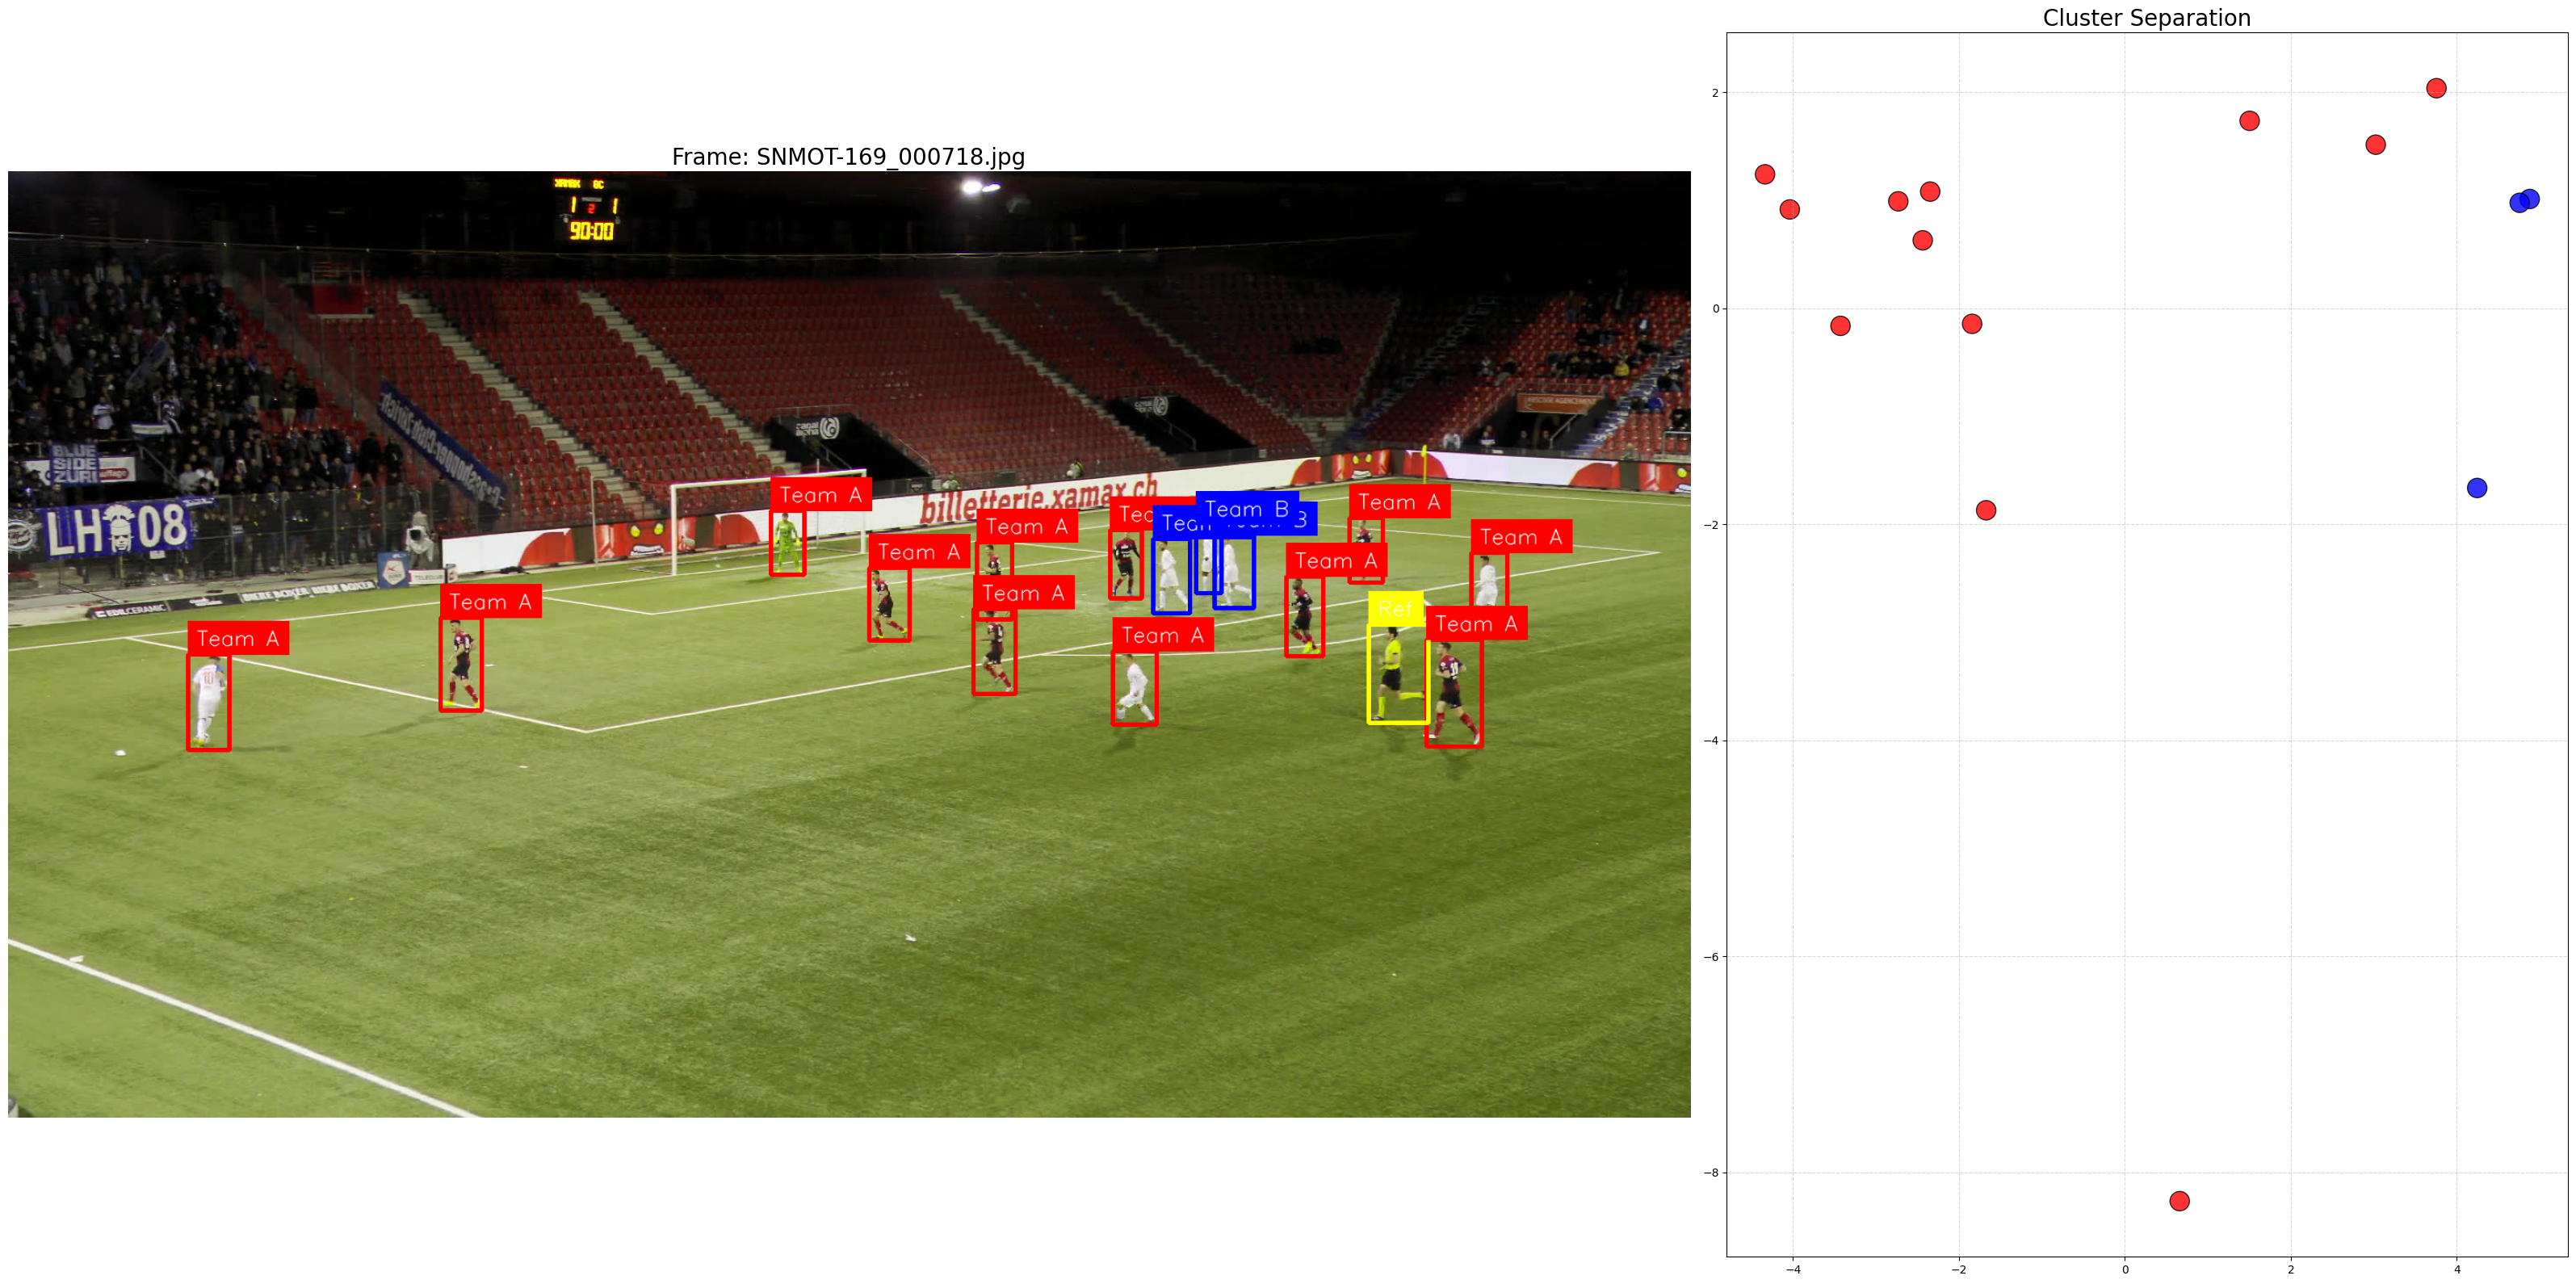

In [34]:
# === CELL 9: High-Res Single Frame Analysis ===
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random
import cv2
import numpy as np
import torch
import supervision as sv

def plot_frame_analysis(frame_path):
    """
    Runs inference on a single frame and plots a LARGE high-res result.
    """
    # 1. Load Image & Inference
    frame = cv2.imread(str(frame_path))
    result = model(frame, imgsz=640, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(result)
    
    # 2. Setup IDs
    player_crops, player_indices = [], []
    new_class_ids = np.full(len(detections), -1)
    labels = [""] * len(detections)
    
    # 3. Extract Crops (Using your new Upper-Body logic)
    for i, (cls_id, xyxy) in enumerate(zip(detections.class_id, detections.xyxy)):
        class_name = model.names[int(cls_id)]
        if class_name == "ball":
            new_class_ids[i] = 3; labels[i] = "Ball"
        elif class_name == "referee":
            new_class_ids[i] = 2; labels[i] = "Ref"
        else:
            crop = get_crop(frame, xyxy)
            if crop:
                player_crops.append(crop)
                player_indices.append(i)
            else:
                new_class_ids[i] = 2; labels[i] = "Skip"

    # 4. Embeddings & Predictions
    embeddings_2d = None
    team_preds = []
    
    if player_crops:
        inputs = processor(images=player_crops, return_tensors="pt", padding="max_length").to(device)
        with torch.no_grad():
            outputs = embed_model(**inputs)
            embeddings = outputs.pooler_output.cpu().numpy()
        
        team_preds = kmeans.predict(embeddings)
        
        if len(embeddings) >= 2:
            pca = PCA(n_components=2)
            embeddings_2d = pca.fit_transform(embeddings)
        
        for i, team_id in zip(player_indices, team_preds):
            if team_id == 0:
                new_class_ids[i] = 0; labels[i] = "Team A"
            else:
                new_class_ids[i] = 1; labels[i] = "Team B"

    # 5. Annotate
    new_class_ids[new_class_ids == -1] = 2 
    detections.class_id = new_class_ids.astype(int)

    colors = sv.ColorPalette([
        sv.Color(r=255, g=0, b=0),      # 0: Red
        sv.Color(r=0, g=0, b=255),      # 1: Blue
        sv.Color(r=255, g=255, b=0),    # 2: Yellow
        sv.Color(r=0, g=255, b=0)       # 3: Green
    ])
    
    box_annotator = sv.BoxAnnotator(color=colors, thickness=3) # Thicker boxes
    label_annotator = sv.LabelAnnotator(color=colors, text_color=sv.Color.WHITE, text_scale=0.8) # Larger text

    annotated_frame = box_annotator.annotate(scene=frame.copy(), detections=detections)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)
    
    # === 6. PLOT (Massive Size) ===
    # figsize=(width, height) in inches. (32, 16) is huge.
    # width_ratios=[2, 1] gives the image 2x more width than the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 16), gridspec_kw={'width_ratios': [2, 1]})
    
    # Image
    ax1.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
    ax1.axis("off")
    ax1.set_title(f"Frame: {frame_path.name}", fontsize=20)
    
    # Scatter
    if embeddings_2d is not None:
        plot_colors = ['red' if t == 0 else 'blue' for t in team_preds]
        ax2.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=plot_colors, s=300, edgecolors='black', alpha=0.8)
        ax2.set_title("Cluster Separation", fontsize=20)
        ax2.grid(True, linestyle='--', alpha=0.5)
    else:
        ax2.text(0.5, 0.5, "Not enough data", ha='center', fontsize=15)
        
    plt.tight_layout()
    plt.show()

# === EXECUTE ===
random_frame = random.choice(match_frames)
print(f"Analyzing frame: {random_frame.name}")
plot_frame_analysis(random_frame)